In [1]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts

In [3]:
occupancy  = pd.read_csv('data/occupancy/occupancy.csv')
features = [
    "temperature", "relative humidity", "light", "C02", "humidity"
]
classes = ["unoccupied", "occupied"]
X = occupancy[features]
y = occupancy['occupancy']

# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

## Current functionality

/Users/peter/.pyenv/versions/3.7.0/lib/python3.7/site-packages/yellowbrick/contrib/scatter.py:211: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_two_cols = X[self.features_].as_matrix()


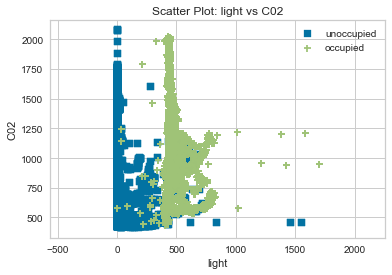

In [4]:
from yellowbrick.contrib.scatter import ScatterVisualizer

visualizer = ScatterVisualizer(
    x="light", y="C02", alpha=0.1, classes=classes
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [8]:
import itertools
import numpy as np

from yellowbrick.features.base import DataVisualizer
from yellowbrick.utils import is_dataframe, is_structured_array
from yellowbrick.utils import has_ndarray_int_columns
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style.colors import resolve_colors


##########################################################################
# Quick Methods
##########################################################################

def scatterviz(X,
               y=None,
               ax=None,
               alpha = 1,
               features=None,
               classes=None,
               color=None,
               colormap=None,
               markers=None,
               **kwargs):
    """Displays a bivariate scatter plot.

    This helper function is a quick wrapper to utilize the ScatterVisualizer
    (Transformer) for one-off analysis.

    Parameters
    ----------

    X : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features

    y : ndarray or Series of length n, default: None
        An array or series of target or class values

    ax : matplotlib axes, default: None
        The axes to plot the figure on.

    features : list of strings, default: None
        The names of two features or columns.
        More than that will raise an error.
        
    classes : list of strings, default: None
        The names of the classes in the target

    color : list or tuple of colors, default: None
        Specify the colors for each individual class

    colormap : string or matplotlib cmap, default: None
        Sequential colormap for continuous target

    markers : iterable of strings, default: ,+o*vhd
        Matplotlib style markers for points on the scatter plot points
    
    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the parallel coordinates were drawn on.
    """
    # Instantiate the visualizer
    visualizer = ScatterVisualizer(ax, features, classes, color, colormap,
                                   markers, **kwargs)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X, y, **kwargs)
    visualizer.transform(X)

    # Return the axes object on the visualizer
    return visualizer.ax


##########################################################################
# Static ScatterVisualizer Visualizer
##########################################################################

class ScatterVisualizer(DataVisualizer):
    """
    ScatterVisualizer is a bivariate feature data visualization algorithm that
    plots using the Cartesian coordinates of each point.

        Parameters
        ----------

        ax : a matplotlib plot, default: None
            The axis to plot the figure on.

        x : string, default: None
            The feature name that corresponds to a column name or index postion
            in the matrix that will be plotted against the x-axis

        y : string, default: None
            The feature name that corresponds to a column name or index postion
            in the matrix that will be plotted against the y-axis

        features : a list of two feature names to use, default: None
            List of two features that correspond to the columns in the array.
            The order of the two features correspond to X and Y axes on the
            graph. More than two feature names or columns will raise an error.
            If a DataFrame is passed to fit and features is None, feature names
            are selected that are the columns of the DataFrame.

        classes : a list of class names for the legend, default: None
            If classes is None and a y value is passed to fit then the classes
            are selected from the target vector.

        color : optional list or tuple of colors to colorize points, default: None
            Use either color to colorize the points on a per class basis or
            colormap to color them on a continuous scale.

        colormap : optional string or matplotlib cmap to colorize points, default: None
            Use either color to colorize the points on a per class basis or
            colormap to color them on a continuous scale.

        markers : iterable of strings, default: ,+o*vhd
            Matplotlib style markers for points on the scatter plot points

        kwargs : keyword arguments passed to the super class.
        
        alpha : float, default: 1.0
            Specify a transparency where 1 is completely opaque and 0 is completely
            transparent. This property makes densely clustered points more visible.

        These parameters can be influenced later on in the visualization
        process, but can and should be set as early as possible.
    """

    def __init__(self,
                 ax=None,
                 x=None,
                 y=None,
                 alpha = 1,
                 features=None,
                 classes=None,
                 color=None,
                 colormap=None,
                 markers=None,
                 **kwargs):
        """
        Initialize the base scatter with many of the options required in order
        to make the visualization work.
        """
        super(ScatterVisualizer, self).__init__(ax, features, classes, color,
                                                colormap, **kwargs)

        self.x = x
        self.y = y
        
        self.alpha = alpha
        
        self.markers = itertools.cycle(
            kwargs.pop('markers', (',', '+', 'o', '*', 'v', 'h', 'd')))

        self.color = color
        self.colormap = colormap

        if self.x is not None and self.y is not None and self.features_ is not None:
            raise YellowbrickValueError(
                'Please specify x,y or features, not both.')

        if self.x is not None and self.y is not None and self.features_ is None:
            self.features_ = [self.x, self.y]
        # Ensure with init that features doesn't have more than two features
        if features is not None:
            if len(features) != 2:
                raise YellowbrickValueError(
                    'ScatterVisualizer only accepts two features.')

    def fit(self, X, y=None, **kwargs):
        """
        The fit method is the primary drawing input for the parallel coords
        visualization since it has both the X and y data required for the
        viz and the transform method does not.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with 2 features

        y : ndarray or Series of length n
            An array or series of target or class values

        kwargs : dict
            Pass generic arguments to the drawing method

        Returns
        -------
        self : instance
            Returns the instance of the transformer/visualizer
        """
        _, ncols = X.shape

        if ncols == 2:
            X_two_cols = X
            if self.features_ is None:
                self.features_ = ["Feature One", "Feature Two"]

        # Handle the feature names if they're None.
        elif self.features_ is not None and is_dataframe(X):
            X_two_cols = X[self.features_].as_matrix()

        # handle numpy named/ structured array
        elif self.features_ is not None and is_structured_array(X):
            X_selected = X[self.features_]
            X_two_cols = X_selected.copy().view((np.float64, len(X_selected.dtype.names)))

        # handle features that are numeric columns in ndarray matrix
        elif self.features_ is not None and has_ndarray_int_columns(self.features_, X):
            f_one, f_two = self.features_
            X_two_cols = X[:, [int(f_one), int(f_two)]]

        else:
            raise YellowbrickValueError("""
                ScatterVisualizer only accepts two features, please
                explicitly set these two features in the init kwargs or
                pass a matrix/ dataframe in with only two columns.""")

        # Store the classes for the legend if they're None.
        if self.classes_ is None:
            # TODO: Is this the most efficient method?
            self.classes_ = [str(label) for label in np.unique(y)]

        # Draw the instances
        self.draw(X_two_cols, y, **kwargs)

        # Fit always returns self.
        return self

    def draw(self, X, y, **kwargs):
        """Called from the fit method, this method creates a scatter plot that
        draws each instance as a class or target colored point, whose location
        is determined by the feature data set.
        """
        # Set the axes limits
        self.ax.set_xlim([-1,1])
        self.ax.set_ylim([-1,1])

        # set the colors
        color_values = resolve_colors(
            n_colors=len(self.classes_),
            colormap=self.colormap,
            colors=self.color
        )

        colors = dict(zip(self.classes_, color_values))

        # Create a data structure to hold the scatter plot representations
        to_plot = {}
        for kls in self.classes_:
            to_plot[kls] = [[], []]

        # Add each row of the data set to to_plot for plotting
        # TODO: make this an independent function for override
        for i, row in enumerate(X):
            row_ = np.repeat(np.expand_dims(row, axis=1), 2, axis=1)
            x_, y_ = row_[0], row_[1]
            kls = self.classes_[y[i]]

            to_plot[kls][0].append(x_)
            to_plot[kls][1].append(y_)

        # Add the scatter plots from the to_plot function
        # TODO: store these plots to add more instances to later
        # TODO: make this a separate function
        for i, kls in enumerate(self.classes_):
            self.ax.scatter(
                to_plot[kls][0],
                to_plot[kls][1],
                marker=next(self.markers),
                color=colors[kls],
                label=str(kls),
                alpha=self.alpha,
                **kwargs)

        self.ax.axis('equal')

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls show and show calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Divide out the two features
        feature_one, feature_two = self.features_

        # Set the title
        self.set_title('Scatter Plot: {0} vs {1}'.format(
            str(feature_one), str(feature_two)))
        # Add the legend
        self.ax.legend(loc='best')
        self.ax.set_xlabel(str(feature_one))
        self.ax.set_ylabel(str(feature_two))


# Alias for ScatterViz
ScatterViz = ScatterVisualizer
            
        

## Now with alpha

/Users/peter/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:206: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


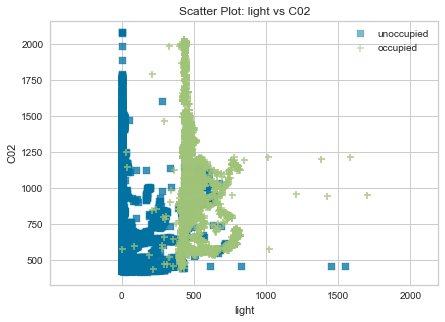

In [9]:
visualizer = ScatterVisualizer(x="light", y="C02", alpha=0.5, classes=classes, size=(500,350))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

/Users/peter/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:206: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


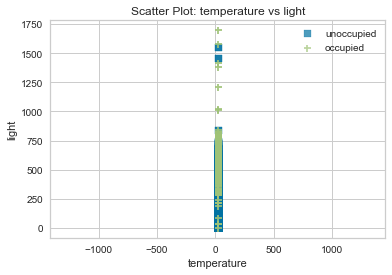

In [10]:
visualizer = ScatterVisualizer(
    x="temperature", y="light", alpha=0.7, classes=classes
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()